In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
# import bokeh
# import scipy
# from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import *

-0.49978557953667957
1.0001673284549355
o2: 34.33125723811366 h2: 0.4280431570586903 0.6473944419694163
umoles O2: 34.33125723811366
e per mol: 1.0870017130711203
1.000162512323718
o2: 33.82052469217551 h2: 1.2740437775780196 405.24650813576255
umoles O2: 33.82052469217551
e per mol: 1.1034217771692103


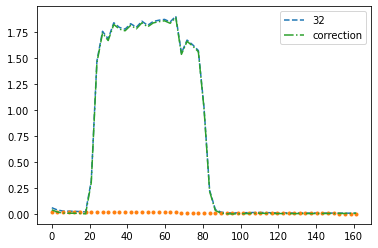

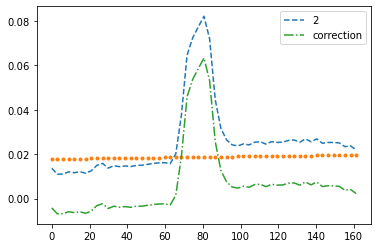

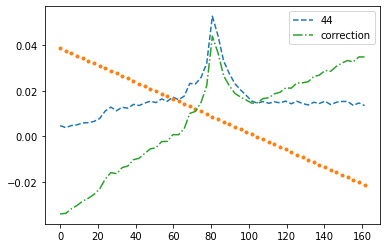

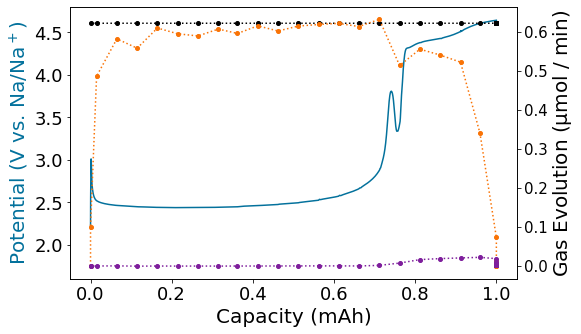

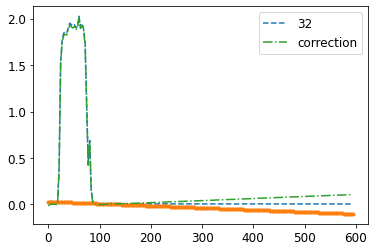

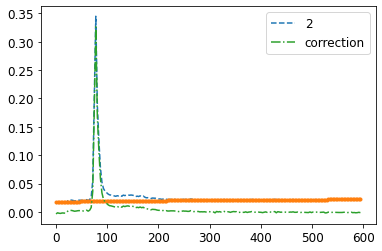

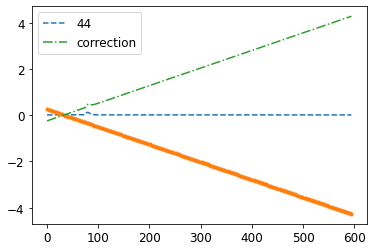

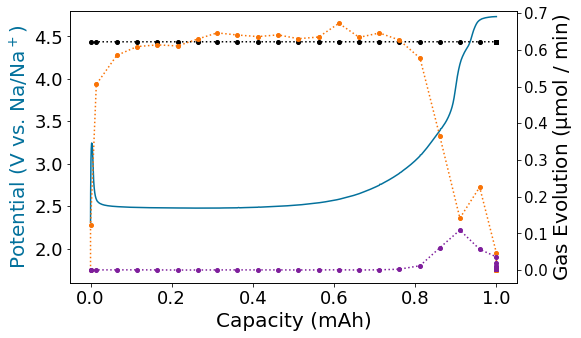

In [14]:
#plot galvanostatic charge
def plot_dems(chrg_ec, demi, r, ethylene='None', n=2 ):
    end_ocv= chrg_ec[1]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    print(np.mean(chrg_ec[1]['I/mA']))
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
      
    cap=[]
    curr=[]
    
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[1]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[1]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[start_charge]

    print ('o2: '+ str(umoles_32), 'h2: ' + str(umoles_2), umoles_44)
    factor= umoles_32/34
    factor=1
    
    if n==2:
        factor=1
    j1= 5
    j2=50
    ax2.plot(umolesdf['Capacity/mAh'][6:50] , 3.6*umolesdf['I/mA'][7:51]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][5:50], (umolesdf['32']/timediff/factor)[6:51] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')   
    ax2.plot(umolesdf['Capacity/mAh'][5:50], (umolesdf['2']/timediff/factor)[6:51] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
    #ax2.plot(umolesdf['Capacity/mAh'][:100], (umolesdf['28']/timediff/factor)[:100] , 'o:', alpha=0 , markersize=4, label = '28')
    #ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['44']/timediff/factor)[j1+1:j2+1] , 'o:', markersize=4, label = 'CO$_2$', color = 'xkcd:irish green')
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    if ethylene !='None':
        ax2.plot((umolesdf['Capacity/mAh'][18:90]), (umolesdf['c2h4']/timediff)[18:90] , 'o:', markersize=4, label = 'C$_2$H$_4$')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    
    #ax2.legend(loc='upper center', bbox_to_anchor=[0.5, 0.85]) #, title= 'm/z value')
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue')
    
    ax.set_ylim([1.6,4.8])
    rc['font.size'] = 12
#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)


    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)


    #     if n==1:
#         epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
#     else:
#         epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    return



na_cp1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_chrg_cycle1_2018-09-28_16.40_19.txt')
na_cp1ec= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/')

print(np.mean(na_cp1ec[9]['I/mA']))
plot_dems(na_cp1ec, na_cp1, 1, n=1)
#plt.savefig('/Users/kedzie/Desktop/qual figures/180928_CP cycle 1 dems_no gases.png', transparent = True, dpi=600, bbox_inches='tight')

secondcycle= [na_cp1ec[3],na_cp1ec[4],na_cp1ec[5]]

na_cp2=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_chrg_cycle2_2018-09-28_22.35_23.txt')
plot_dems(secondcycle, na_cp2, 2, n=1)

#plt.savefig('/Users/kedzie/Desktop/qual figures/180928_CP cycle 2 dems.png', transparent = True, dpi=600, bbox_inches='tight')




In [ ]:
voltagelimit=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190803_Na_MCMB_voltagelimit_dems/190803_Na_MCMB_voltagelimit_dems_p_2019-08-03_12.07_09.txt')
potentials= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190803_Na_MCMB_voltagelimit_dems/')

plt.figure()
plt.plot(voltagelimit['time/min'], voltagelimit['32'])
#plt.plot(voltagelimit['time/min'], voltagelimit['2'])
plt.plot(voltagelimit['time/min'], voltagelimit['44'])
plt.legend()

umolesdf = convert_ion_current(voltagelimit) 
plt.figure()
plt.plot(umolesdf['time/min'], umolesdf['32'])
plt.plot(umolesdf['time/min'], umolesdf['2'])
plt.plot(umolesdf['time/min'], umolesdf['44'])
plt.xlim(0,250)
end_ocv= potentials[3]['time/s'].iloc[-1]/60
    
# oxy = baselinecorr( umolesdf, 32, potentials[0]['time/s'].iloc[-1], end_ocv)
# hydro = baselinecorr( oxy, 2, potentials[0]['time/s'].iloc[-1], end_ocv)
# co2 = baselinecorr( hydro, 44, potentials[0]['time/s'].iloc[-1], end_ocv)
# umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
timediff= np.mean(np.gradient(umolesdf['time/min']))

fig, ax= plt.subplots() 
ax2=ax.twinx()
plt.xlim(-2,250)
ax2.plot(umolesdf['time/min'],umolesdf['2'] ,'o--', markersize=5)
ax2.plot(umolesdf['time/min'],umolesdf['32'] ,'o--', markersize=5)
ax2.plot(umolesdf['time/min'],umolesdf['44'] ,'o--', markersize=5)
ax.plot(potentials[0]['time/s']/60, potentials[0]['Ewe/V'], 'xkcd:cerulean' )
ax.plot(potentials[1]['time/s']/60, potentials[1]['Ewe/V'], 'xkcd:cerulean' )
ax.plot(potentials[2]['time/s']/60, potentials[2]['Ewe/V'], 'xkcd:cerulean' )
ax.plot(potentials[3]['time/s']/60, potentials[3]['Ewe/V'], 'xkcd:cerulean' )
plt.ylim(-0.1,0.8)

ax2.legend()
ax.set_xlabel("Time (min)")
ax.set_ylabel("Potential (V vs. Na$^+$/Na$^0$)")
ax2.set_ylabel('Gas Evolution ($\mu$moles)')

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190803_Na_MCMB_voltagelimit_dems/voltage limit mcmb dems.png', transparent = True, dpi=600, bbox_inches='tight')




cp_mcmb= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190804_Na_MCMB_CP_dems/')
cp_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190804_Na_MCMB_CP_dems/190804_Na_MCMB_CP_dems_chrg_2019-08-04_19.47_26.txt')

#plot_dems(cp_mcmb, cp_dems, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/MCMB graphite CP dems.png', transparent = True, dpi=600, bbox_inches='tight')



In [9]:
def baselinecorr(data, mz, baseline_start, baseline_end):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], baseline_start/60)-1
    index2 = getnearpos(data['time/min'], baseline_end)
    endocvtime= getnearpos(data['time/min'], baseline_end+50)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))


    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][:index], str(mz) : data[str(mz)][:index], }
    d2 =  {'time/min' : data['time/min'][index2:], str(mz): data[str(mz)][index2:] }

    df = pd.DataFrame(d); df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape
    
    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2+3]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2+3]-fullfile['time/min'].iloc[time1])
        return m
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
#         fullfile[str(mz)]= fullfile[str(mz)] - line
#         for i in range(0,index):
#             fullfile[str(mz)].iloc[i]=fullfile[str(mz)].iloc[i]-fullfile[str(mz)].iloc[i]
#         for i in range(index2,len(fullfile)):   
#             fullfile[str(mz)].iloc[i]=fullfile[str(mz)].iloc[i]-fullfile[str(mz)].iloc[i]
#         for i in range (index,index2):
#             fullfile[str(mz)].iloc[i]= fullfile[str(mz)].iloc[i] - line.iloc[i]
        return m #fullfile
    
    if mz == 2:
        m= slope( data, mz, index+1, index2 )
        #correct= 2*10**-5*data['time/min'] + 0.028
        #correct = 5*10**-5*data['time/min'] +0.005 #na cp cycle1
        #correct = 1*10**-7*data['time/min'] +0.02 #na cp cycle2
        #correct = 1*10**-5*data['time/min'] +0.0173 #na CA cycle1
        correct= -9.8617*10**-9*data['time/min']**2 + 1.2971*10**-5*data['time/min'] + 1.7803*10**-2
        #correct=(m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        

        
    elif mz == 32:
        m= slope( data, mz, index, index2+3 )
        #correct = m*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        correct = (m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        
        #correct = -4.0880*10**-6*data['time/min'] + 1.0521*10**-1
    elif mz == 44:
        m= slope( data, mz, index+20, index2 )
        #correct = -2*10**-5*data['time/min'] + 0.029
        #correct= 1*10**-5*data['time/min'] +0.0055 #na cp cycle1
        #correct= -5*10**-6*data['time/min'] +0.015 #na cp cycle2
        #correct= -5*10**-6*data['time/min'] +0.03 #na CA cycle1
        correct = (m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index+20]
        

    plt.plot(data['time/min'], correct, '.')
    data[str(mz)] = data[str(mz)]-correct
    #plt.xlim(0,200)
    
    #fullfile=correct
    #data[str(mz)] = data[str(mz)]-correct
    
    #co1= np.polyfit(np.log(newdf['time/min']), newdf[str(mz)], deg=1)
    #baselinecorr= co1[0]*np.log(data['time/min'])+col[1]
    #data[str(mz)] = data[str(mz)]-baselinecorr
    
    #recomment this for linear baseline
    #correct=lin( data, data['time/min'], data[str(mz)], index-1, index2 )
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()                            
    
    return (data)


In [15]:

#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #new as of 
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 288.7462016 * demsdata['36']   #as of 2/2019
    
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
       
    
#     for i in range(len(names)):
#         demsdata[names[i]] = demsdata[names[i]] * vol / R / ( demsdata['temperature/C'] + 273 )

    return (demsdata) 


end cap: 0.9998122188780044
0.9079581623276074
25.837851 microamps
487.74017653012527
0.9079581623276074
29.898723305792952 0.40686402288879897 0.014850737496175576
umoles O2: 29.898723305792952
e per mol: 1.1330677868048018


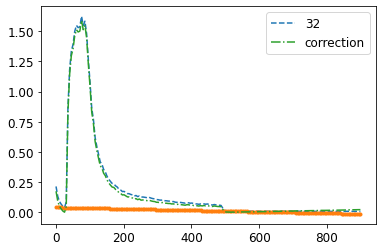

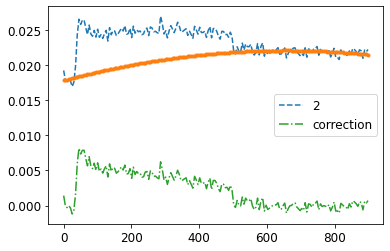

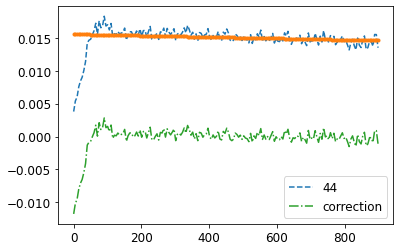

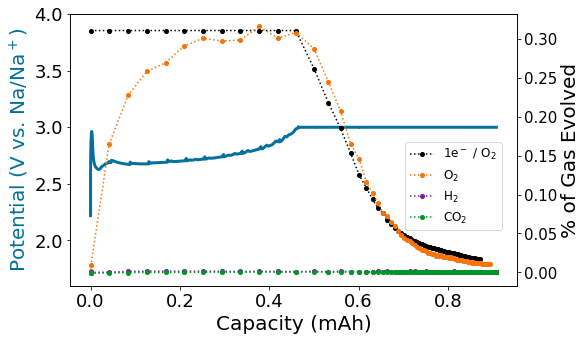

In [16]:
#c13= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/190213_Na_CA_C13_18O2cycling_cell1_chrg_cycle1_2019-02-13_12.42_12_ch1.txt')
#c13_ec = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/')
#plot_dems2(c13_ec, c13,200, r=1, n=1)


mcmbdem= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_MCMB_CA_dems/190413_Na_graphite_MCMB_CA_dems_chrg_2019-04-13_15.20_46_ch1.txt')
mcmb_fold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_MCMB_CA_dems/')
mcmb_all= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_MCMB_CA_dems/')

print('end cap: ' + str(mcmb_all[1]['Capacity/mA.h'].iloc[-1]))
end1=mcmb_fold[1]['Capacity/mA.h'].iloc[-1]
end2=mcmb_fold[2]['Capacity/mA.h'].iloc[-1]
endi=mcmb_fold[3]['I/mA'].iloc[-1]

print(end1+end2+mcmb_fold[3]['Capacity/mA.h'].iloc[-1])
print(str(endi*10**6) + ' microamps')
print(mcmb_fold[3]['time/s'].iloc[-1]/60)

# plt.figure()
# plt.plot(mcmb_fold[1]['Capacity/mA.h'], mcmb_fold[1]['I/mA'], 'orange')
# plt.plot(mcmb_fold[2]['Capacity/mA.h'] + end1, mcmb_fold[2]['I/mA'], 'orange')
# plt.plot(mcmb_fold[3]['Capacity/mA.h'] + end1+end2, mcmb_fold[3]['I/mA'], 'orange')
#plt.savefig('/Users/kedzie/Desktop/mcmb dems current.png', transparent = True, dpi=600, bbox_inches='tight')


plot_dems2(mcmb_fold, mcmbdem, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/MCMB CA dems percent.png', transparent = True, dpi=600, bbox_inches='tight')


#plt.savefig('/Users/kedzie/Desktop/mcmb dems.png', transparent = True, dpi=600, bbox_inches='tight')

# preddem= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_pred_CA_dems/190413_Na_graphite_pred_CA_dems_chrg_2019-04-13_15.20_46_ch2.txt')
# pred_fold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_pred_CA_dems/')

# print(pred_fold[1]['Capacity/mA.h'].iloc[-1]+pred_fold[2]['Capacity/mA.h'].iloc[-1]+pred_fold[3]['Capacity/mA.h'].iloc[-1])

# plot_dems2(pred_fold, preddem, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/pred dems.png', transparent = True, dpi=600, bbox_inches='tight')





In [17]:
#plot chronoamperometric charge on DEMS
def plot_dems2(chrg_ec, demi, r, ethylene='None', n=1 , percent='None'):
    #oxyi= baselinecorr( demi, 36, chrg_ec[0]['time/s'].iloc[-1], time_min)
    end_ocv= chrg_ec[3]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    #pdb.set_trace()
    #convert ion current to moles of gas for baseline corrected data
    umolesdf = co2
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    timediff= np.mean(np.gradient(umolesdf['time/min']))

    
    chrg_ec[2]['Capacity/mA.h'] += chrg_ec[1]['Capacity/mA.h'].iloc[-1]
    if n==1:
        chrg_ec[3]['Capacity/mA.h'] += chrg_ec[2]['Capacity/mA.h'].iloc[-1]
        print(chrg_ec[3]['Capacity/mA.h'].iloc[-1])    
    charge_i= np.mean(chrg_ec[1]['I/mA'])  #normalize charge current by surface area (mA/cm2)
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    cap=[]
    curr=[]
    if n==1:
        new=pd.concat([chrg_ec[1], chrg_ec[2], chrg_ec[3]], sort=True)
    else:
        new=pd.concat([chrg_ec[1], chrg_ec[2]], sort=True)
        
    for j in range( len(umolesdf)):  
        
        index=getnearpos( new['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])
        #print( str(new['time/s'].iloc[index]/60) + ' and '+ str(umolesdf['time/min'].iloc[j]) )

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    
    x= [0.0, chrg_ec[2]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[3]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[5]
    print (umoles_32, umoles_2, umoles_44)
    factor=1
    #ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
#     ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff/factor)[5:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    
    if percent=='on':
        ax2.plot(umolesdf['Capacity/mAh'][6:90] , (umolesdf['32']/total_umoles*100)[7:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:tangerine')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['2']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:burnt orange')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['44']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'CO$_2$', color='xkcd:maroon', alpha=0.9)
    else:
        ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
        ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff/factor)[4:90] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
        ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
        ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    

    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    ax2.legend( bbox_to_anchor=(0.98, 0.55))
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax.plot(chrg_ec[2]['Capacity/mA.h'], chrg_ec[2]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    if n==1:
        ax.plot(chrg_ec[3]['Capacity/mA.h'], chrg_ec[3]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    

#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    #ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax2.set_ylabel('% of Gas Evolved', fontsize=20)
    ax.set_ylim([1.6,4.0])
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    if n==1:
        epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
    else:
        epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    #plt.title("Cycle " + str(r))
    return




0.9689096444182926
33.17647757362289 0.09477209495515261 0.5666076615491805
umoles O2: 33.17647757362289
e per mol: 1.089671781436938
0.9927928861644532
34.70394814008871 0.01330530855399252 0.04069663179723055
umoles O2: 34.70394814008871
e per mol: 1.067388379706864
1.012276319993867
34.20447991030842 0.2611201096666236 1.8613720982396689
umoles O2: 34.20447991030842
e per mol: 1.1042280777078533


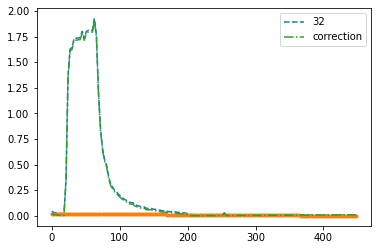

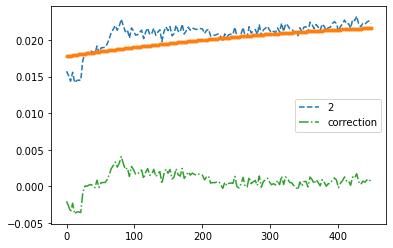

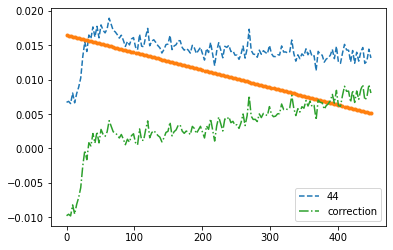

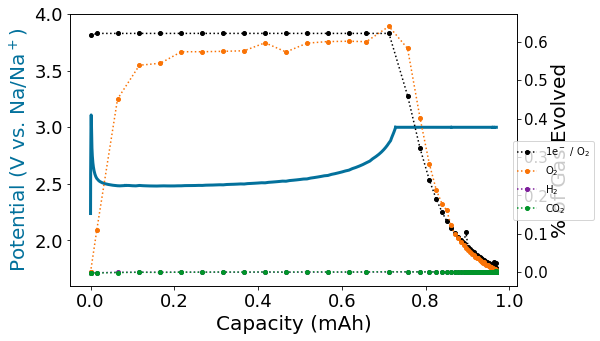

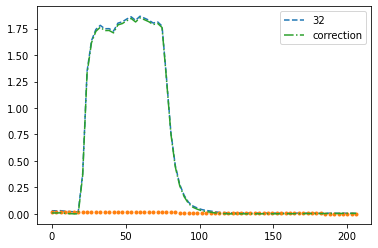

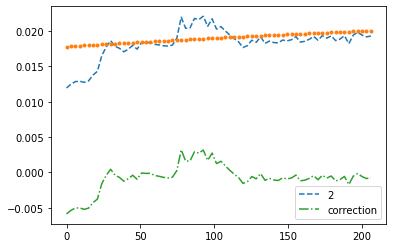

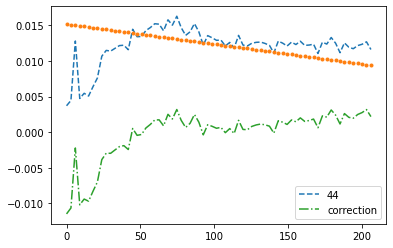

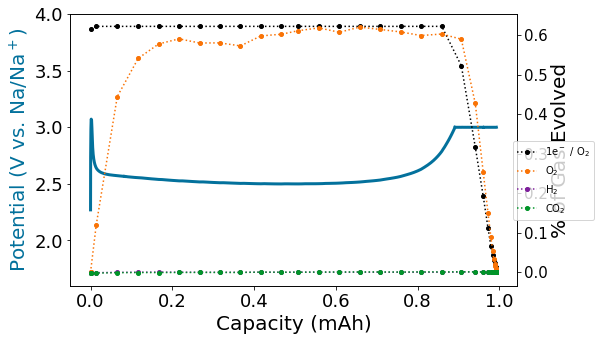

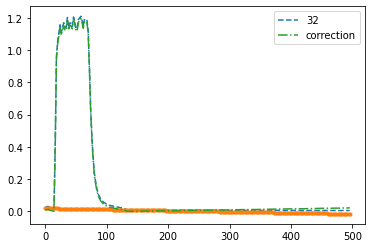

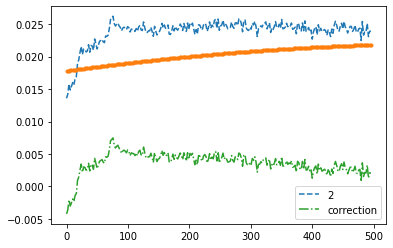

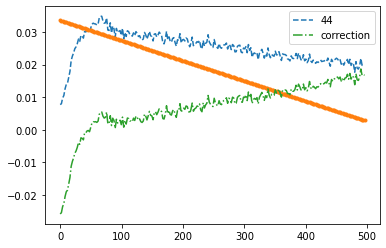

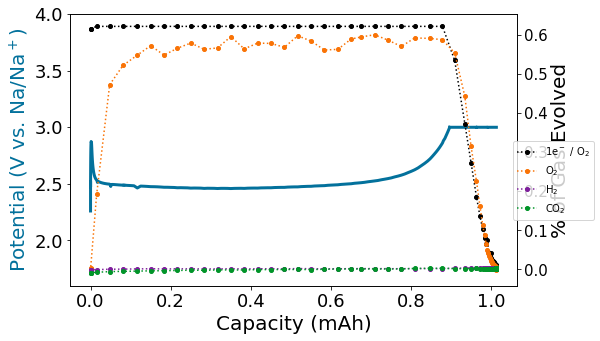

In [13]:
goodCAdemsfold=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/')
goodCA_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180819_Na_chronoamp_cyclingstudy_dems_chrg_cycle1_2018-08-19_22.50_51.txt')
cycle2= [goodCAdemsfold[5],goodCAdemsfold[6],goodCAdemsfold[7],goodCAdemsfold[8]]
cycle2_dems=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180820_Na_chronoamp_cyclingstudy_dems_chrg_cycle2_2018-08-20_16.06_42.txt')


plot_dems2(goodCAdemsfold, goodCA_dems, 1, n=1)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180819_Na_CA_dems_chrg_cycle1.png', transparent = True, dpi=600, bbox_inches='tight')


plot_dems2(cycle2, cycle2_dems, 2, n=1)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180819_Na_CA_dems_chrg_cycle2.png', transparent = True, dpi=600, bbox_inches='tight')



na_dems = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180709_sodium_chronoamp_3V_DEMS_2/')
na_dems2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180709_sodium_chronoamp_3V_DEMS_2/180709_sodium_chronoamp_3V_DEMS_2_chrg_rnd2_2018-07-09_18.48_40.txt')
# na_disch= read_data('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180709_sodium_chronoamp_3V_DEMS_2/180709_sodium_chronoamp_3V_DEMS_2_disch_05_CP_C01.mpt')

#plot_dems2(na_dems, na_dems2, 1, n=1)
#plt.savefig('/Users/kedzie/Desktop/qual figures/180709 sodium dems charge cycle1.png', transparent = True, dpi=600, bbox_inches='tight')

#sodium_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/')
#sodium_chrg1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/180718_Sodium_chronoamp_2cycles_dems_chrg_cycle1_2018-07-18_13.41_28.txt')
#CYCLE 2 SHORTED
#cycle2= [sodium_fold[5],sodium_fold[6],sodium_fold[7],sodium_fold[8]]
#sodium_chrg2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/180718_Sodium_chronoamp_2cycles_dems_chrg_cycle2_2018-07-18_20.37_41.txt')
#plot_dems2(cycle2, sodium_chrg2, 2,  n=1)
#plot_dems2(sodium_fold, sodium_chrg1, 1,  n=1)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/Na CA dems cycle1 plot.png', transparent = True, dpi=600, bbox_inches='tight')


#this  cell 1 showed weird (lower than usual) gas evolution on charge 
cycles_fold=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180731_sodiumchronoamp_2cycles_1mA_dems/')
cy1_dems =read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180731_sodiumchronoamp_2cycles_1mA_dems/180731_sodiumchronoamp_2cycles_1mA_dems_chrg_c1_2018-07-31_12.43_13.txt')
#plot_dems2(cycles_fold, cy1_dems, 1, n=1)
#plt.savefig('/Users/kedzie/Desktop/180731_sodium dems CA cycle1.png', transparent = True, dpi=600, bbox_inches='tight')

#this was a -1mA discharge and 1mA charge
cy2fold = [cycles_fold[5], cycles_fold[6],cycles_fold[7], cycles_fold[8]]
cy2_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180731_sodiumchronoamp_2cycles_1mA_dems/180731_sodiumchronoamp_2cycles_1mA_dems_chrg_c2_2018-07-31_17.42_35.txt')
plot_dems2(cy2fold, cy2_dems, 2,  n=1)
#plt.savefig('/Users/kedzie/Desktop/qual figures/180731_sodium dems CA cycle2.png', transparent = True, dpi=600, bbox_inches='tight')






0.8071058409081565
-0.04301828843020612 0.289712295326837 -1.8239678439024076
umoles O2: -0.04301828843020612
e per mol: -700.0354973119931


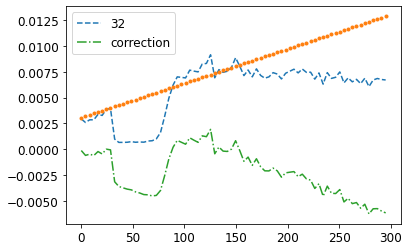

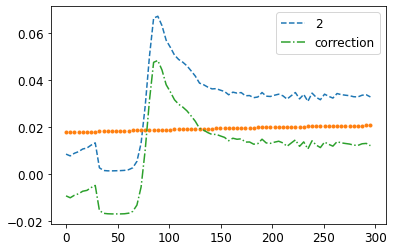

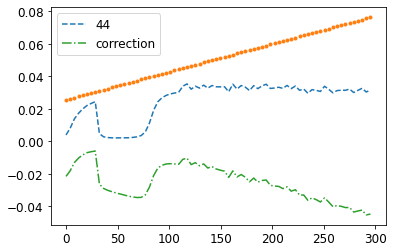

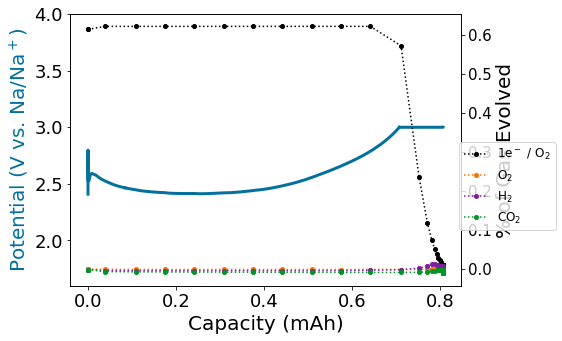

In [11]:
fold1='/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/'
isotope1= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/')
d1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/190213_Na_CA_C13_18O2cycling_cell1_chrg_cycle1_2019-02-13_12.42_12_ch1.txt')

plot_dems2(isotope1, d1, r=1, n=1)


0.9689096444182926
33.17647757362289 0.09477209495515261 0.5666076615491805
umoles O2: 33.17647757362289
e per mol: 1.089671781436938
0.9927928861644532
34.70394814008871 0.01330530855399252 0.04069663179723055
umoles O2: 34.70394814008871
e per mol: 1.067388379706864


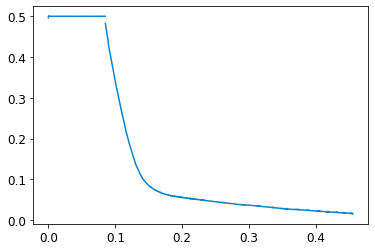

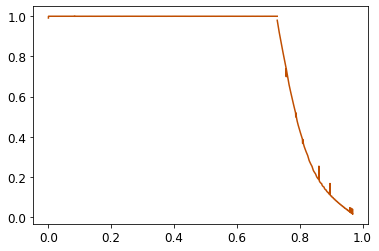

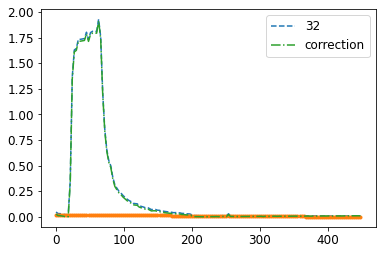

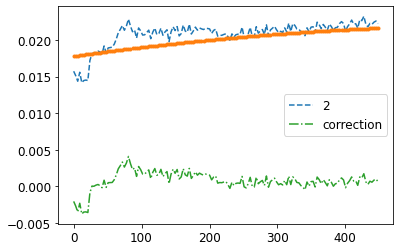

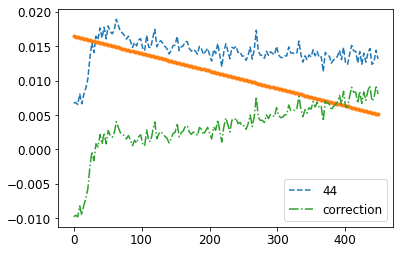

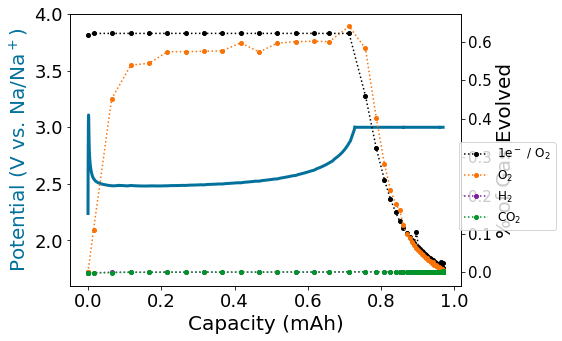

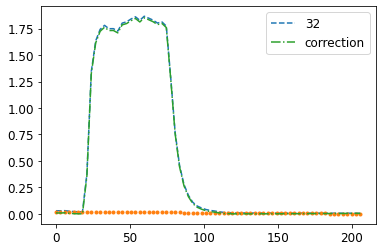

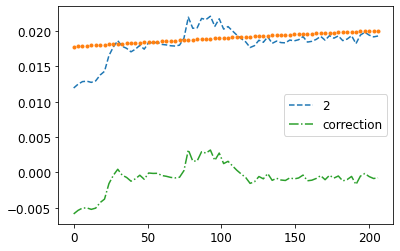

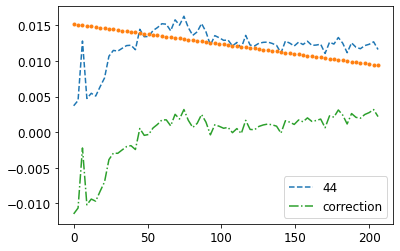

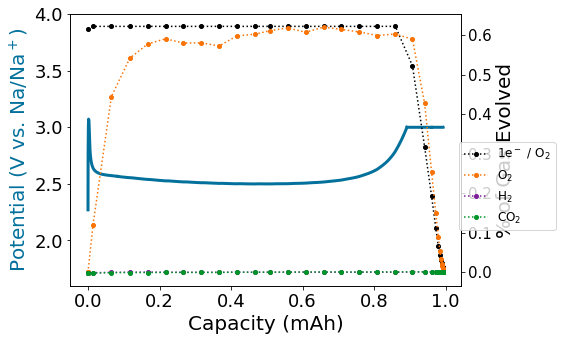

In [12]:

# plt.figure()
# plt.plot(disch1['Capacity/mA.h'], disch1['Ewe/V'], 'xkcd:cerulean', label='')
# plt.plot(1-cycles_fold[3]['Capacity/mA.h'], cycles_fold[3]['Ewe/V'], 'xkcd:cerulean', label='cycle 1')
# plt.plot(1-cycles_fold[2]['Capacity/mA.h'], cycles_fold[2]['Ewe/V'], 'xkcd:cerulean', label='')
# plt.plot(1-cycles_fold[1]['Capacity/mA.h'], cycles_fold[1]['Ewe/V'], 'xkcd:cerulean', label='')

# plt.plot(disch2['Capacity/mA.h'], disch2['Ewe/V'], 'xkcd:orange', label='cycle 2')
# plt.plot(1-cy2fold[1]['Capacity/mA.h'], cy2fold[1]['Ewe/V'], 'xkcd:orange', label='')
# plt.plot(1-cy2fold[2]['Capacity/mA.h'], cy2fold[2]['Ewe/V'], 'xkcd:orange', label='')
# plt.plot(1-cy2fold[3]['Capacity/mA.h'], cy2fold[3]['Ewe/V'], 'xkcd:orange', label='')

# plt.legend()

water=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180726_2000ppmwater_LiTFSI_chronoamp_dems/')
waterdems=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180726_2000ppmwater_LiTFSI_chronoamp_dems/180726_2000ppmwater_LiTFSI_chronoamp_dems_chrg_2018-07-26_15.25_53.txt')
dis= read_data('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180726_2000ppmwater_LiTFSI_chronoamp_dems/180726_2000ppmwater_LiTFSI_chronoamp_dems_disch_03_CP_C01.mpt')
allwater= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180809_2000ppmwater_LiTFSI_chronoamp_4V_dems/')
plt.figure()
plt.plot(allwater[1]['Capacity/mA.h'], allwater[1]['I/mA'], 'xkcd:cerulean', label ='')
plt.plot(allwater[1]['Capacity/mA.h'].iloc[-1]+ allwater[2]['Capacity/mA.h'], allwater[2]['I/mA'], 'xkcd:cerulean', label='Li')

na_ca_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/')
demscy1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180819_Na_chronoamp_cyclingstudy_dems_chrg_cycle1_2018-08-19_22.50_51.txt')

na_ca_c2 = na_ca_fold[5:10]
dc2  = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180820_Na_chronoamp_cyclingstudy_dems_chrg_cycle2_2018-08-20_16.06_42.txt')
plt.figure()
plt.plot(na_ca_fold[1]['Capacity/mA.h'], na_ca_fold[1]['I/mA'], 'xkcd:burnt orange', label='')
plt.plot(na_ca_fold[1]['Capacity/mA.h'].iloc[-1]+na_ca_fold[2]['Capacity/mA.h'], na_ca_fold[2]['I/mA'], 'xkcd:burnt orange', label='')
plt.plot(na_ca_fold[1]['Capacity/mA.h'].iloc[-1]+na_ca_fold[2]['Capacity/mA.h'].iloc[-1]+na_ca_fold[3]['Capacity/mA.h'], na_ca_fold[3]['I/mA'], 'xkcd:burnt orange', label='Na')

plot_dems2(na_ca_fold, demscy1, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/dems na ca c1.png', transparent = True, dpi=600, bbox_inches='tight')
plot_dems2(na_ca_c2, dc2, r=2, n=1)
#plt.savefig('/Users/kedzie/Desktop/dems na ca c2.png', transparent = True, dpi=600, bbox_inches='tight')


0.9144054767158296
25.3902536694248 1.139538796239931 0.2419281219223559
umoles O2: 25.3902536694248
e per mol: 1.3437376268156966


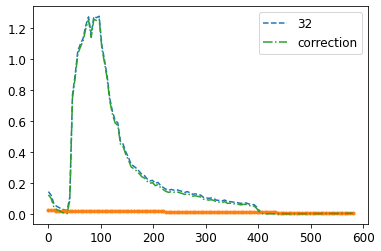

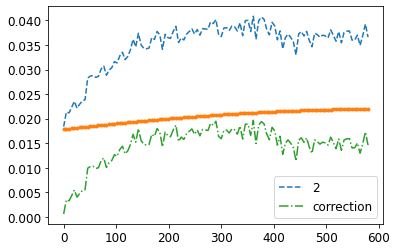

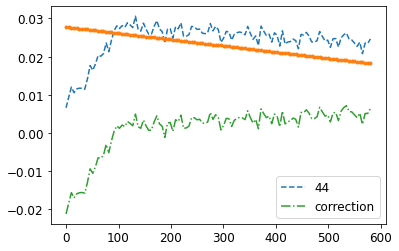

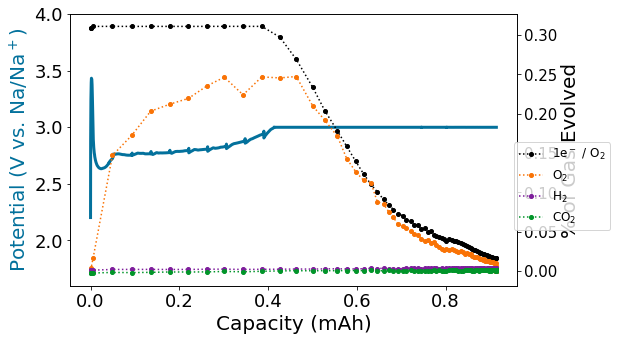

In [13]:

mcmb_CA_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/200717_Na_MCMB0709_CA_dems_cell1_chrg_cy1_2020-07-17_13.55_25_ch1.txt')
mcmb_CA_dems_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/')

plot_dems2(mcmb_CA_dems_fold, mcmb_CA_dems, r=1, n=1)

In [17]:


#-------------------------  script to plot dems  ------------------------------
#tdpa without nitrate
# demi=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_withoutNO3_DEMS_disch_chrg/180606_TDPA_withoutNO3_DEMS_chrg_2018-06-06_17.35_38.txt')
# chrg_ec=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_withoutNO3_DEMS_disch_chrg/')

#litfsi
# demi2=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_LiNO3_DEMS_chrg_only/180606_TDPA_LiNO3_DEMS_chrg_2018-06-06_17.35_38.txt')
# litfsi_ec=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_LiNO3_DEMS_chrg_only/')

# tdpa_OG=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_25mMTDPA_disch_chrg/180510_25mMTDPA_chrg_dems_2018-05-10_15.13_09.txt')
# tdpa_ec=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_25mMTDPA_disch_chrg/')

dems_litfsi=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_1MLiTFSI_DME_disch_chrg_dems/180510_1MLiTFSI_DME_chrg_dems_2018-05-10_15.13_09.txt')
litfsi_ec2 = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_1MLiTFSI_DME_disch_chrg_dems/')
#plot_dems(litfsi_ec2, dems_litfsi)
# plt.savefig('/Users/kedzie/Desktop/dems_litfsi_control.png', transparent = True, dpi=600, bbox_inches='tight')


# plot_dems(tdpa_ec, tdpa_OG)

# #plt.savefig('/Users/kedzie/Desktop/dems_tdpa_nitrate.png', transparent = True, dpi=600, bbox_inches='tight')


# plot_dems(chrg_ec, demi)

#plt.savefig('/Users/kedzie/Desktop/dems_tdpa_nonitratecontrol.png', transparent = True, dpi=600, bbox_inches='tight')

#plot_dems(litfsi_ec,demi2)
#plt.savefig('/Users/kedzie/Desktop/dems_lino3tdpa_chargeonly.png', transparent = True, dpi=600, bbox_inches='tight')


6.599383653426295 -0.6047915734565626 nan
umoles O2: 6.599383653426295
e per mol: 5.205469179735265


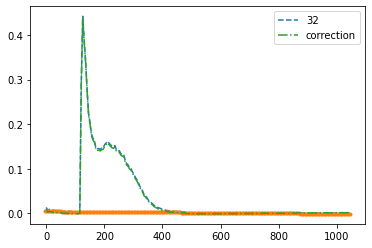

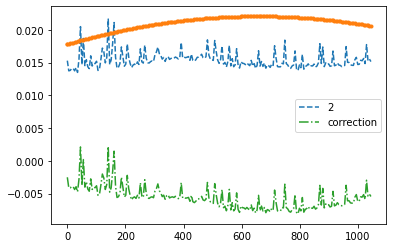

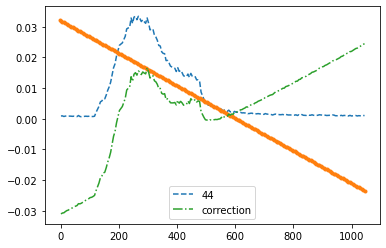

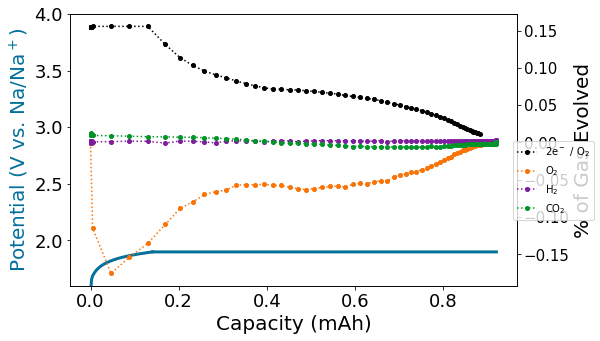